In [95]:
import warnings
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

from torch.utils.data import Dataset
import numpy as np
from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
mpl.rc('image', cmap='gray')

%matplotlib inline

In [96]:
class NumpyArrayDataset(Dataset):
    def __init__(self, path, transformer=None):
        self.npzfile = np.load(path)
        self.img_shape = self.npzfile[self.npzfile.files[0]][0].shape
        self.transformer = transformer
    
    def __getitem__(self, idx):
        img = self.npzfile[self.npzfile.files[idx]].astype(np.single)
    
        entry = self.npzfile[self.npzfile.files[idx]]
    
        noisy_image = (25500 * entry[0]).astype('uint8')
        true_image = (25500 * entry[0]).astype('uint8')
        
        noisy_image = Image.fromarray(noisy_image)
        true_image = Image.fromarray(true_image)
        
#         print(noisy_image.mean())
        # For compatibility with the convolutional layers in the
        # network, we need to reshape the image to make it explicit 
        # that the image consists of one layer. 
#         noisy_image = 100 * np.stack((entry[0], entry[0], entry[0]))
#         true_image  = 100 * np.stack((entry[1], entry[1], entry[1]))
    
        if transformer is not None:
            noisy_image = self.transformer(noisy_image)
            true_image = self.transformer(true_image)
            
        print(noisy_image.mean())
    
        # entry[0] is the noisy image, entry[1] is the true image. The
        # goal will be for the network to learn the mapping
        # noisy --> true.
        return (noisy_image, true_image)
    
    def __len__(self):
        return len(self.npzfile)


In [97]:
batch_size = 32
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64), antialias=True),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])

path = "shapes-dataset-new.npz"

# Load the shapes dataset as a PyTorch Dataset
pokemon = NumpyArrayDataset(path, transformer)

pokemon.transform = transformer
pokemon.transform = None
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size,
    shuffle=True, num_workers=1)

In [98]:
len(data_iter)

32

tensor(-0.8517)
tensor(-0.9393)
tensor(-0.7550)
tensor(-0.9193)
tensor(-0.9570)
tensor(-0.7809)
tensor(-0.8859)
tensor(-0.8778)
tensor(-0.8919)
tensor(-0.8619)
tensor(-0.8653)
tensor(-0.8007)
tensor(-0.8275)
tensor(-0.8636)
tensor(-0.9162)
tensor(-0.6306)
tensor(-0.8794)
tensor(-0.9119)
tensor(-0.6197)
tensor(-0.8831)
tensor(-0.8359)
tensor(-0.9084)
tensor(-0.8123)
tensor(-0.8802)
tensor(-0.8539)
tensor(-0.8588)
tensor(-0.9045)
tensor(-0.9093)
tensor(-0.8282)
tensor(-0.8904)
tensor(-0.9186)
tensor(-0.6992)
tensor(-0.7376)
tensor(-0.9675)
tensor(-0.8930)

tensor(-0.7522)tensor(-0.6556)
tensor(-0.8905)
tensor(-0.7271)
tensor(-0.8722)
tensor(-0.8474)
tensor(-0.9813)
tensor(-0.8678)
tensor(-0.8023)
tensor(-0.7808)
tensor(-0.9536)
tensor(-0.7504)
tensor(-0.9565)
tensor(-0.7968)
tensor(-0.8246)
tensor(-0.7747)
tensor(-0.8931)
tensor(-0.8547)
tensor(-0.9382)
tensor(-0.8882)
tensor(-0.9080)
tensor(-0.9006)
tensor(-0.9089)
tensor(-0.8642)
tensor(-0.9603)
tensor(-0.9681)
tensor(-0.7705)
tensor(-

/tmp/ipykernel_13048/1199429665.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


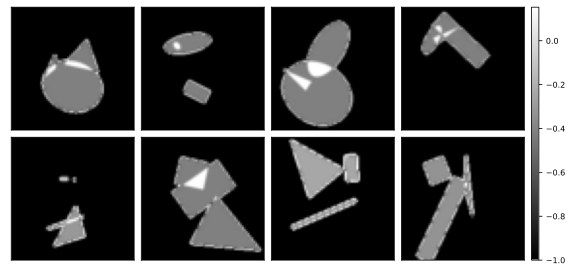

In [99]:
# warnings.filterwarnings('ignore')
# d2l.set_figsize((16, 16))
# for X, y in data_iter:
#     imgs = X[0:8,:,:,:].permute(0, 2, 3, 1)/2+0.5
#     d2l.show_images(imgs, num_rows=2, num_cols=4)
#     break

plt.rcParams.update({'font.size': 8})

fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(2,4),
                 axes_pad=(0.1, 0.1),
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3%",
                 cbar_pad=0.1,
                 )

for X, y in data_iter:
    imgs = X[0:8,:,:,:].permute(0, 2, 3, 1)
    
    for ax, img in zip(grid, imgs):
        pic = ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
    
    break
    
ax.cax.colorbar(pic)
ax.cax.toggle_label(True)
plt.tight_layout()

In [100]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))


In [101]:
x = torch.zeros((2, 3, 16, 16))
g_blk = G_block(20)
g_blk(x).shape


torch.Size([2, 20, 32, 32])

In [53]:
x = torch.zeros((2, 3, 1, 1))
g_blk = G_block(20, strides=1, padding=0)
g_blk(x).shape


torch.Size([2, 20, 4, 4])

In [54]:
n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G*8,
            strides=1, padding=0),                  # Output: (64 * 8, 4, 4)
    G_block(in_channels=n_G*8, out_channels=n_G*4), # Output: (64 * 4, 8, 8)
    G_block(in_channels=n_G*4, out_channels=n_G*2), # Output: (64 * 2, 16, 16)
    G_block(in_channels=n_G*2, out_channels=n_G),   # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=1,
                       kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())  # Output: (3, 64, 64)


In [55]:
x = torch.zeros((1, 100, 1, 1))
net_G(x).shape


torch.Size([1, 1, 64, 64])

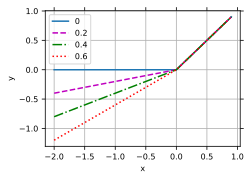

In [56]:
alphas = [0, .2, .4, .6, .8, 1]
x = torch.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(x).detach().numpy() for alpha in alphas]
d2l.plot(x.detach().numpy(), Y, 'x', 'y', alphas)


In [57]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=1, kernel_size=4, strides=2,
                padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))


In [58]:
x = torch.zeros((2, 1, 16, 16))
d_blk = D_block(20)
d_blk(x).shape


torch.Size([2, 20, 8, 8])

In [59]:
n_D = 64
net_D = nn.Sequential(
    D_block(n_D),  # Output: (64, 32, 32)
    D_block(in_channels=n_D, out_channels=n_D*2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D*2, out_channels=n_D*4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D*4, out_channels=n_D*8),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D*8, out_channels=1,
              kernel_size=4, bias=False))  # Output: (1, 1, 1)


In [60]:
x = torch.zeros((1, 1, 64, 64))
net_D(x).shape


torch.Size([1, 1, 1, 1])

In [61]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat(
            [torch.cat([
                fake_x[i * 7 + j].cpu().detach() for j in range(7)], dim=1)
             for i in range(len(fake_x)//7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')


loss_D 0.249, loss_G 2.559, 206.9 examples/sec on cuda:0


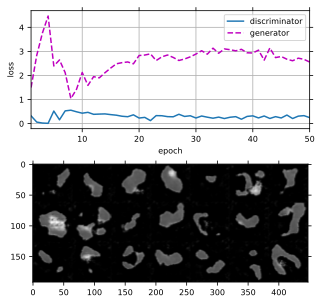

In [62]:
latent_dim, lr, num_epochs = 100, 0.0002, 50
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)


/tmp/ipykernel_13048/2098129364.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


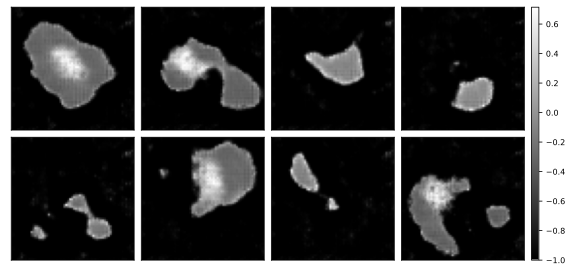

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

net_G = net_G.to(device)
net_D = net_D.to(device)

plt.rcParams.update({'font.size': 8})

fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(2,4),
                 axes_pad=(0.1, 0.1),
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3%",
                 cbar_pad=0.1,
                 )

for ax in grid:
    Z = torch.normal(0, 1, size=(batch_size, 100, 1, 1)).to(device)
    fake_pic = net_G(Z)
    pic = ax.imshow(fake_pic.detach().cpu()[0].permute(1, 2, 0))
    ax.set_xticks([])
    ax.set_yticks([])
    
    
ax.cax.colorbar(pic)
ax.cax.toggle_label(True)
plt.tight_layout()

# for X, Z in data_iter:
#     for orig_pic, noisy_pic, _ in zip(X, Z, range(10)):        
#         plt.imshow(orig_pic[0])
#         print(net_D(orig_pic.view(1, 1, 128, 128).to('cuda')))
#         plt.show()
#         fake_pic = net_G(noisy_pic.view(1, 1, 128, 128).to('cuda'))
#         print(net_D(fake_pic))
#         pic = plt.imshow(fake_pic[0, 0].detach().cpu())
#         plt.colorbar(pic)
#         plt.show()
    
#     break